# LSTM을 이용한 로이터 뉴스 카테고리 분류

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
seed= 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
from tensorflow.keras.datasets import reuters
(X_train, y_train), (X_test, y_test) = \
    reuters.load_data(num_words=None, test_split=0.2)

2113536/2110848 [==============================] - 0s 0us/step


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [4]:
category = np.max(y_train) + 1
print(category, '카테고리')
print(len(X_train), '학습용 뉴스 기사')
print(len(X_test), '테스트용 뉴스 기사')

46 카테고리
8982 학습용 뉴스 기사
2246 테스트용 뉴스 기사


In [5]:
print(X_train[0])
print(y_train[0])

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
3


In [6]:
index_dict = {}
for key, value in reuters.get_word_index().items():
    index_dict[value] = key
len(index_dict)

557056/550378 [==============================] - 0s 0us/step


30979

In [7]:
# 첫번째 기사 복원
' '.join(index_dict[s] for s in X_train[0])

'the wattie nondiscriminatory mln loss for plc said at only ended said commonwealth could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln home an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 psbr oils several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed largely april 0 are 2 states will billion total and against 000 pct dlrs'

In [8]:
# 뉴스 기사의 길이
print('뉴스 기사의 최대 길이 :', max(len(l) for l in X_train))
print('뉴스 기사의 평균 길이 :', sum(map(len, X_train))/len(X_train))

뉴스 기사의 최대 길이 : 2376
뉴스 기사의 평균 길이 : 145.5398574927633


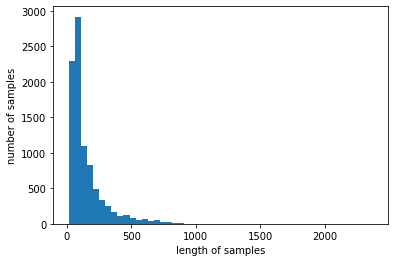

In [9]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


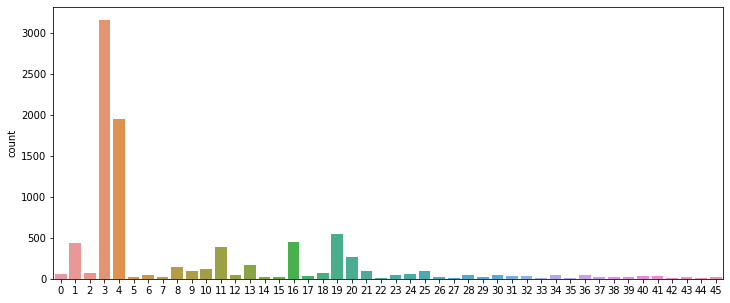

In [10]:
# 뉴스 분포
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(y_train);

In [11]:
unique_elements, counts_elements = \
    np.unique(y_train, return_counts=True)
label_cnt = dict(zip(unique_elements, counts_elements))
print("각 레이블에 대한 빈도수:")
print(label_cnt)

각 레이블에 대한 빈도수:
{0: 55, 1: 432, 2: 74, 3: 3159, 4: 1949, 5: 17, 6: 48, 7: 16, 8: 139, 9: 101, 10: 124, 11: 390, 12: 49, 13: 172, 14: 26, 15: 20, 16: 444, 17: 39, 18: 66, 19: 549, 20: 269, 21: 100, 22: 15, 23: 41, 24: 62, 25: 92, 26: 24, 27: 15, 28: 48, 29: 19, 30: 45, 31: 39, 32: 32, 33: 11, 34: 50, 35: 10, 36: 49, 37: 19, 38: 19, 39: 24, 40: 36, 41: 30, 42: 13, 43: 21, 44: 12, 45: 18}


### LSTM으로 로이터 뉴스 분류
- 모든 단어가 아닌 빈도수 1000 까지 (총단어수 : 30979)
- 모든 문장이 아니라 100 단어 까지 (최대 2376단어)

In [12]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [13]:
# 등장 빈도가 1,000번째까지의 단어들만 사용
(X_train, y_train), (X_test, y_test) = \
    reuters.load_data(num_words=1000, test_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [14]:
# 모델의 입력으로 사용하는 모든 뉴스 기사의 길이를 동일하게 100으로 맞춤
max_len = 100
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [15]:
# 뉴스 기사 레이블의 원-핫 인코딩
Y_train = to_categorical(y_train) 
Y_test = to_categorical(y_test)

In [16]:
# LSTM 모델
model = Sequential()
model.add(Embedding(1000, 120))
model.add(LSTM(120))
model.add(Dense(46, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 120)         120000    
_________________________________________________________________
lstm (LSTM)                  (None, 120)               115680    
_________________________________________________________________
dense (Dense)                (None, 46)                5566      
Total params: 241,246
Trainable params: 241,246
Non-trainable params: 0
_________________________________________________________________


In [17]:
# 모델의 컴파일
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [18]:
# Callback 함수 정의 - Best model, Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('model/reuter_best_model.h5', monitor='val_loss', 
                     mode='max', verbose=1, save_best_only=True)

In [19]:
# 모델의 실행
history = model.fit(X_train, Y_train, batch_size=100, epochs=50, 
                    validation_split=0.2, verbose=2,
                    callbacks=[mc, es])

Epoch 1/50
72/72 - 10s - loss: 2.6485 - accuracy: 0.3464 - val_loss: 2.3789 - val_accuracy: 0.3450

Epoch 00001: val_loss improved from -inf to 2.37887, saving model to model/reuter_best_model.h5
Epoch 2/50
72/72 - 1s - loss: 2.1259 - accuracy: 0.4630 - val_loss: 2.1107 - val_accuracy: 0.4836

Epoch 00002: val_loss did not improve from 2.37887
Epoch 3/50
72/72 - 1s - loss: 1.8997 - accuracy: 0.5196 - val_loss: 1.7468 - val_accuracy: 0.5559

Epoch 00003: val_loss did not improve from 2.37887
Epoch 4/50
72/72 - 1s - loss: 1.7332 - accuracy: 0.5566 - val_loss: 1.7443 - val_accuracy: 0.5570

Epoch 00004: val_loss did not improve from 2.37887
Epoch 5/50
72/72 - 1s - loss: 1.6814 - accuracy: 0.5685 - val_loss: 1.6705 - val_accuracy: 0.5776

Epoch 00005: val_loss did not improve from 2.37887
Epoch 6/50
72/72 - 1s - loss: 1.6686 - accuracy: 0.5680 - val_loss: 1.6727 - val_accuracy: 0.5748

Epoch 00006: val_loss did not improve from 2.37887
Epoch 7/50
72/72 - 1s - loss: 1.5653 - accuracy: 0.598

In [20]:
# Best Model 선택
best_model = load_model('model/reuter_best_model.h5')

In [21]:
acc = model.evaluate(X_test, Y_test, verbose=2)[1]
print(f"\n 테스트 정확도: {acc:.4f}")

71/71 - 0s - loss: 1.3612 - accuracy: 0.6959

 테스트 정확도: 0.6959


In [22]:
# 검증셋
y_vloss = history.history['val_loss']
y_vacc = history.history['val_accuracy']
# 학습셋
y_loss = history.history['loss']
y_acc = history.history['accuracy']

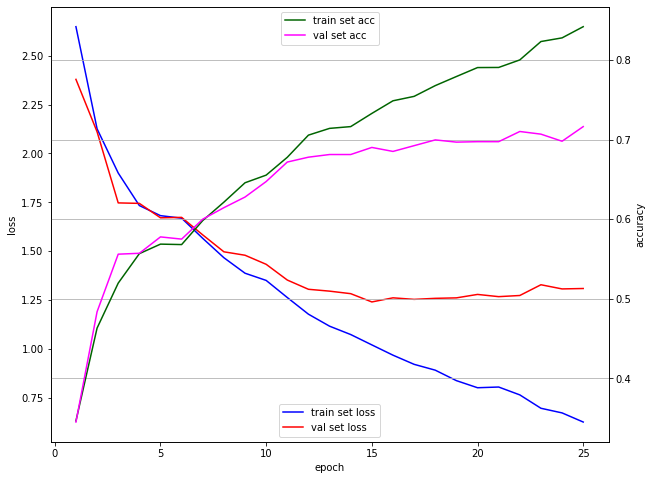

In [23]:
x_len = np.arange(1, len(y_loss)+1)
fig, ax0 = plt.subplots(figsize=(10,8))
ax1 = ax0.twinx()
ax0.plot(x_len, y_loss, c="blue", label='train set loss')
ax0.plot(x_len, y_vloss, c="red", label='val set loss')
ax0.set_ylabel('loss')
ax1.plot(x_len, y_acc, c="darkgreen", label='train set acc')
ax1.plot(x_len, y_vacc, c="magenta", label='val set acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='lower center')
ax1.legend(loc='upper center')
plt.grid()
plt.show()